In [1]:
import os
import sys
import tqdm
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import seed
from skopt import BayesSearchCV
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error

sys.path.append('.')
sys.path.append('../../')
sys.path.append('../network_model/')
sys.path.append('../validation/')

notebook_path = os.getcwd()
project_path = os.path.abspath(os.path.join(notebook_path, '..'))
sys.path.append(project_path)

from network_model.network_classes import Network
from networks_container import NetworksContainer
from estimator import Estimator

In [2]:
cherrypicked_seed = 42

seed(cherrypicked_seed)
random.seed(cherrypicked_seed)

In [3]:
epochs = 1000

In [4]:
n_nodes = 2000
n_nodes

2000

In [5]:
n_bots = 0
n_bots

0

In [6]:
n_fact_checkers = round((2 / 100) * n_nodes)
n_fact_checkers

40

In [7]:
# circa 1 influencer ogni 100 utenti
n_influencers = 20

In [8]:
n_commons = n_nodes - n_bots - n_fact_checkers - n_influencers
n_commons

1940

In [9]:
n_initial_infected_nodes = round((5 / 100) * n_nodes) - n_bots
n_initial_infected_nodes

100

In [10]:
parameters_homophily_025 = pd.read_csv("../validation/parameters/parameters_optimization_palin_hours_homophily_0.25.csv")
parameters_homophily_050 = pd.read_csv("../validation/parameters/parameters_optimization_palin_hours_homophily_0.50.csv")
parameters_homophily_075 = pd.read_csv("../validation/parameters/parameters_optimization_palin_hours_homophily_0.75.csv")

In [11]:
parameters_df = pd.concat([parameters_homophily_025, parameters_homophily_050, parameters_homophily_075])

In [12]:
parameters_df = parameters_df.sort_values(by='rmse')
parameters_df

,alpha,beta,homophily,prob_infection,prob_vaccination,prob_cure,prob_influencer,prob_echo,rmse
8,0.25,0.50,0.50,0.443859,0.098546,0.127511,0.941369,0.042834,2.061167
16,0.50,0.33,0.75,0.024295,0.238505,0.627572,0.860890,0.610532,3.607667
15,0.50,0.25,0.25,0.946572,0.019471,0.806971,0.485082,0.630385,3.665503
13,0.33,0.50,0.50,0.100720,0.029019,0.626069,0.359240,0.451349,3.733030
16,0.50,0.33,0.50,0.856125,0.187407,0.125657,0.702822,0.868028,3.921738
...,...,...,...,...,...,...,...,...,...
10,0.33,0.00,0.50,0.877706,0.198097,0.047475,0.338947,0.740148,32.870191
0,0.00,0.00,0.50,0.347875,0.328040,0.842198,0.947431,0.422984,33.392833
5,0.25,0.00,0.50,0.861757,0.366898,0.452570,0.447949,0.823765,33.414271
0,0.00,0.00,0.25,0.347875,0.328040,0.842198,0.947431,0.422984,33.445233


In [13]:
alpha = parameters_df['alpha'].iloc[0]
beta = parameters_df['beta'].iloc[0]
homophily = parameters_df['homophily'].iloc[0]
prob_infection = parameters_df['prob_infection'].iloc[0]
prob_vaccination = parameters_df['prob_vaccination'].iloc[0]
prob_cure = parameters_df['prob_cure'].iloc[0]
prob_influencer = parameters_df['prob_influencer'].iloc[0]
prob_echo = parameters_df['prob_echo'].iloc[0]

In [14]:
prob_complaint = 0.00

In [15]:
container = NetworksContainer(n_networks=1, n_nodes=n_nodes, 
                              alpha=alpha, beta=beta, 
                              delta_in=1, delta_out=1, 
                              homophily=homophily, n_commons=n_commons, 
                              n_influencers=n_influencers, n_bots=n_bots, 
                              n_fact_checkers=n_fact_checkers,
                              prob_complaint=prob_complaint, 
                              prob_infection=prob_infection, 
                              prob_vaccination=prob_vaccination,
                              prob_cure=prob_cure, 
                              prob_influencer=prob_influencer, 
                              exp_decay=True, user_block=False, 
                              prob_echo=prob_echo, epochs=epochs)
container.create_network_list(n_initial_infected_nodes=n_initial_infected_nodes)

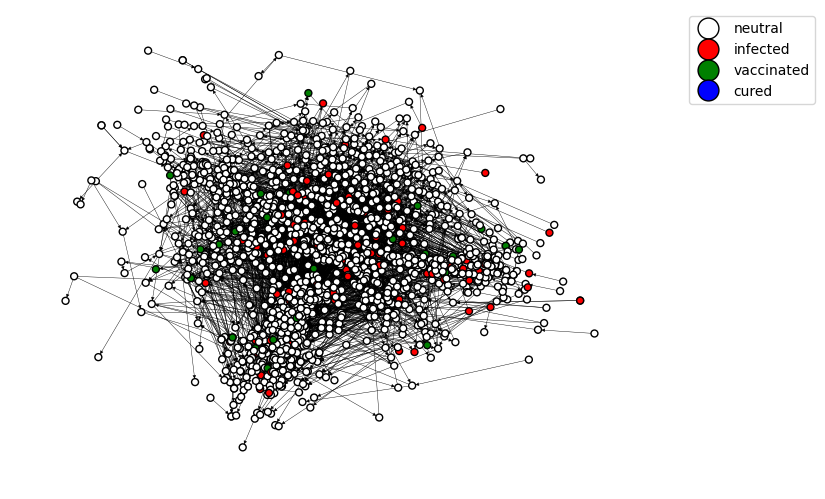

In [16]:
container.network_list[0].plot_graph_sirv()

In [17]:
for j in range(container.epochs):
    container.network_list[0].update_nodes()

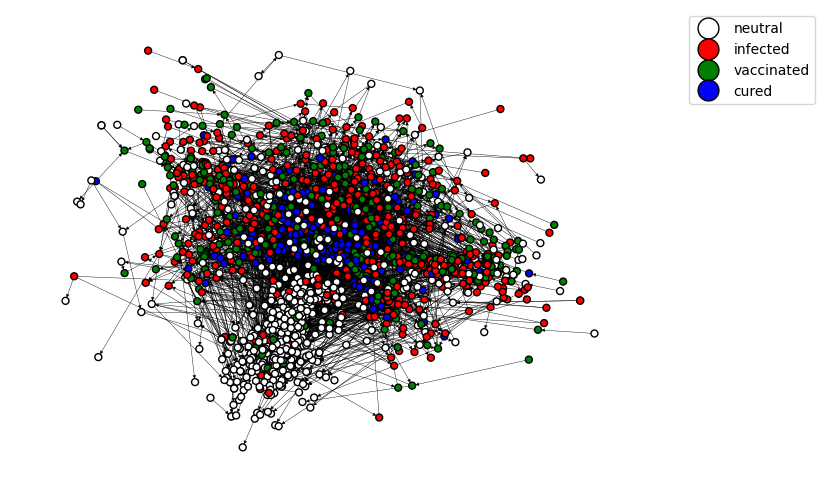

In [18]:
container.network_list[0].plot_graph_sirv()

In [19]:
df_with_bots = pd.read_csv("./simulation results/simulation_with_bots_obama_endorsers_percentages.csv", header=None)
df_with_bots = df_with_bots.transpose()
df_without_bots = pd.read_csv("./simulation results/simulation_without_bots_obama_endorsers_percentages.csv", header=None)
df_without_bots = df_without_bots.transpose()

In [20]:
total_y_pred_list = df_with_bots.values.tolist()
total_y_pred_list_no_bots = df_without_bots.values.tolist()

In [21]:
avg_y_pred_list = [sum(column) / len(column) for column in zip(*total_y_pred_list)]
avg_y_pred_list_no_bots = [sum(column) / len(column) for column in zip(*total_y_pred_list_no_bots)]

In [22]:
std_y_pred_list = [np.std(column) for column in zip(*total_y_pred_list)]
std_y_pred_list_no_bots = [np.std(column) for column in zip(*total_y_pred_list_no_bots)]

In [23]:
std_low_y_pred_list = []
std_high_y_pred_list = []

for i in range(len(avg_y_pred_list)):
    std_low_y_pred_list.append(avg_y_pred_list[i] - std_y_pred_list[i])
    std_high_y_pred_list.append(avg_y_pred_list[i] + std_y_pred_list[i])

In [24]:
std_low_y_pred_list_no_bots = []
std_high_y_pred_list_no_bots = []

for i in range(len(avg_y_pred_list_no_bots)):
    std_low_y_pred_list_no_bots.append(avg_y_pred_list_no_bots[i] - std_y_pred_list_no_bots[i])
    std_high_y_pred_list_no_bots.append(avg_y_pred_list_no_bots[i] + std_y_pred_list_no_bots[i])

In [25]:
x = []
for i in range(epochs + 1):
    x.append(i)

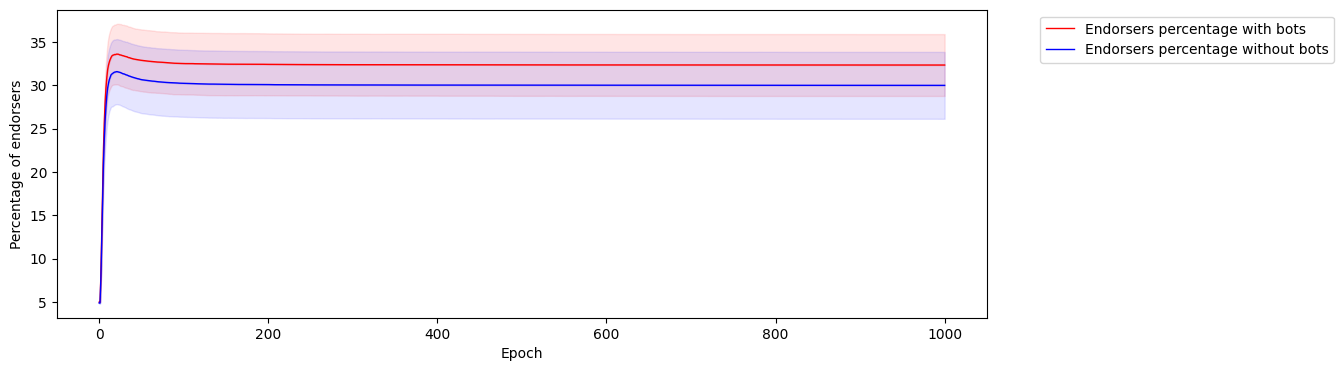

In [26]:
fig, axs = plt.subplots(1, 1, figsize=(12, 4))
axs.plot(avg_y_pred_list, c='r', label='Endorsers percentage with bots', linewidth=1.0)
axs.fill_between(x, avg_y_pred_list, std_low_y_pred_list, color='r', alpha=.1)
axs.fill_between(x, avg_y_pred_list, std_high_y_pred_list, color='r', alpha=.1)
plt.plot(avg_y_pred_list_no_bots, c='b', label='Endorsers percentage without bots', linewidth=1.0)
axs.fill_between(x, avg_y_pred_list_no_bots, std_low_y_pred_list_no_bots, color='b', alpha=.1)
axs.fill_between(x, avg_y_pred_list_no_bots, std_high_y_pred_list_no_bots, color='b', alpha=.1)
legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Epoch")
plt.ylabel("Percentage of endorsers")
plt.show()